<a href="https://colab.research.google.com/github/SArham/understanding_ml/blob/master/Understanding_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Convolutions**


Hi, to understand convolutions, we are going to need to learn a couple of basics beforehand.

We need to know about

1.   Linear Algebra
2.   Matrices
3.   Programming


Linear Algebra and Matrices:

Here, I will just refer you to [3blue1brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab). This playlist will teach you everything and more you need to know about to understand convolutions.







# **What is a Convolution?**

[Maths](https://en.wikipedia.org/wiki/Convolution): A mathematical operation on two functions (f and g) that produces a third function expressing how the shape of one is modified by the other.

In the context of a Neural Network, a convolution is the process of a [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) [a matrix of (n, m) shape] sliding across the input matrix and each point the filter moves to, the output is written a corresponding location in the output matrix.
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/ad00478081591e8d289b7b1eba7448050acb1fed)

Mathematically, the Convolution we perform in ANNs, is [Cross-corelation.](https://en.wikipedia.org/wiki/Cross-correlation)

Visually, this is how the above equation processes like.


![alt text](https://media.giphy.com/media/i4NjAwytgIRDW/source.gif)

The filter is usually a square in shape. 

The input to the convolution will always be larger or equal to its output.

Each step of this process, the hadamard product is calculated of the cropped input and the kernel/filter. The output of the operation is then summed/weighted summed and the result is set as the pixel value of the output matrix.

The [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) is just the fancy-shmancy word for element-wise product of 2 matrices. 



In [0]:
import os
from math import floor, ceil
from random import randint
import requests

import numpy as np
import cv2

from google.colab.patches import cv2_imshow

The following function allows you to download images from their url. 
You can do the following:
1.   You can supply the url to the function from where to fetch the image.
2.   You can set the location where the image would be saved.

If you do not provide it a url or a saving location. It will 



In [0]:
# Photo by chuttersnap on Unsplash. It's a pretty big image.
def get_image(url='https://unsplash.com/photos/dCSdghHE6IE/download?force=true', 
              location="./test.jpg",
							overwrite=False):
	if overwrite or not os.path.exists(location):
		f = open(location, 'wb')
		f.write(requests.get(url).content)
		f.close()
	image = cv2.imread(location)
	bg_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	return bg_im

# **calculate_output_size:**

Receives:
1.  l = The input dimension to the convolution.
2.  k = kernel size.
3.  p = padding size
4.  s = stride lenght.


To check if the output of the convolution is correct. Enter the kernel size, stride and padding values in the following calculator by fomoro.

VALID padding means that 
https://fomoro.com/research/article/receptive-field-calculator

# **convolution2D:**

Receives 
1.  an image [a matrix of size w x h], 2 dimensional input matrix
2.  an optional input of a 2D kernel/filter matrix can be given. It has to be a numpy array. 
3.  [optional] stride of the kernel ca nbe given.
4.  [optional] kernel size can be given. This will be overwritten if a kernel is inputted into the function.
5.  padding can be set to VALID=False, or SAME=True.

Logic:


If the kernel/filter is not given. A random filter is created from a uniform distribution between the values of -100 to 100 of the of the matrix size [kernel_size, kernel_size].
Otherwise, the entered filter's size is retrieved and set to the kernel_size.

The weight "normalizes" the element-wise product. 

The input matrix dimensions are set to h, w.

[Padding is calculated](https://stats.stackexchange.com/questions/297678/how-to-calculate-optimal-zero-padding-for-convolutional-neural-networks) :
Padding = (Kernel_Size−1) / 2


If we want to pad, we pad accordingly, otherwise, we don't. 

Then we calculate the output shape after the convolution operation.

We create the output matrix and fill it with zeros.

Iterating is different for padded and non-padded inputs. Although, both ranges start from the same value, the padded input starts from the (0, 0) value of the original image while the non-padded input starts from the ( [kernel_size/2] /  [kernel_size/2] ) value. This is why, the output dimesion decreases by this (kernel_size/2) value. This happens, as without padding, at matrix center (0, 0), of the input, a cropped matrix of (kernel_size)/(kernel_size) is impossible as you will be going out of bound at the left and top side.e

We iterate through the input matrix according to the stride. Crop out an area equal to the filter and then calculate the elementwise product of the filter and the cropped input. We sum it and place at the appropriate index of the output matrix.

1.  j represents the height index.
2.  i represents the width index.

Once, we have iterated through all the points/pixels/indexes/locations of the input matrix with the filter, we have an output matrix and we return it.




In [0]:
def calculate_output_size(l, k, p, s):
	return int(((l-k +(2*p))/s)+ 1)

def convolution2D(image, filter=None, stride=5, kernel_size=4, padding=False):	
  # https://en.wikipedia.org/wiki/Kernel_(image_processing)
  if filter is None:
    filter = np.random.uniform(low=-100.0, high=100.0, size=(kernel_size, kernel_size))
  else:
    kernel_size = filter.shape[0]
  weight = 1./np.sum(filter, axis=(0, 1))
  # [https://wikimedia.org/api/rest_v1/media/math/render/svg/ad00478081591e8d289b7b1eba7448050acb1fed]

  h, w = image.shape

  padded = ceil((kernel_size-1)/2)
  if padding:
    image = np.pad(image, padded, 'constant', constant_values=0)
    oh, ow = calculate_output_size(h, kernel_size, padded, stride), \
              calculate_output_size(w, kernel_size, padded, stride)
  else:
    oh, ow = calculate_output_size(h, kernel_size, 0, stride), \
              calculate_output_size(w, kernel_size, 0, stride)
  post_processed_image = np.zeros((oh, ow))
  oi, oj = 0, 0
  jrange = range(padded, h+padded, stride) if padding else range(padded, h-padded, stride)
  irange = range(padded, w+padded, stride) if padding else range(padded, w-padded, stride)
  for j in jrange:
    oi = 0
    for i in irange:
      cropped_area = image[(j-padded):(j+kernel_size-padded), 
                (i-padded):(i+kernel_size-padded)]
      v = weight * np.sum(cropped_area * filter, axis=(0, 1))
      v = 0 if v < 0 else 255 if v > 255 else v
      post_processed_image[oj, oi] = v
      oi += 1
    oj += 1
  print(f'{image.shape} ---> {post_processed_image.shape},'
        +f'{filter.shape}, {stride}, {padding}')
  return post_processed_image

# Let's play this out like how a normal network would... in the start.

The function below takes the image, we downloaded and does the convolution n amounts of times. You can set it however many times you want to but be vary with the speed at which the image size decreases. This is one of the main reasons convolutions are used for images. 

They, inherently, take into consideration the location of pixels and their distance to one another. They also decrease the dimensionality of the output considerably allowing for leaner and less complex computation and networks.

If you are using the image, I am using, the first layer will take some time but the rest would be much much faster due to the size and thus the no. of calculations required.

Play around, all inputs are tuples or lists with the first value being the inclusive lower bound and the 2nd value being the exclusive upper bound value. 

In [0]:
def process_random(no_of_convs, strides, ksizes):
	image_list = []
	image_list.append(get_image())
	for i in range(randint(no_of_convs[0], no_of_convs[1])):
		image_list.append(convolution2D(image_list[-1],
																	stride=randint(strides[0], strides[1]), 
																	kernel_size=randint(ksizes[0], ksizes[1]), 
																	padding=(True if randint(0, 1)== 1 else False)))
	for imid, image in enumerate(image_list):
		cv2.imwrite(f"./processed{imid}.jpg", image)
	return image_list

In [0]:
im_list = process_random((2, 7), (1, 4), (3, 7))

for imid, image in enumerate(im_list):
  im = cv2.resize(cv2.imread(f'./processed{imid}.jpg'), (720, 480), cv2.INTER_LINEAR)
  cv2_imshow(im)

In [0]:
image = cv2.imread("./test.jpg")
im1 = convolution2D(image, stride=4, kernel_size=5, padding=True)
cv2_imshow(im1)

In [0]:
filters = [[[0, 0, 0], [0, 1, 0], [0, 0, 0]],             # Identity
           [[1, 0, -1], [0, 0, 0], [-1, 0, 1]],           # Edge Detection [Roberts]
           [[0, -1, 0], [-1, 4, -1], [0, -1, 0]],            # Edge Detection [Laplacian] 
           [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]],     # Edge Detection [Laplacian]
           [[0, -1, 0], [-1, 5, -1], [0, -1, 0]],         # Sharpening
           [[1, 0, -1], [2, 0, -2], [1, 0, -1]],          # Vertical Sobel-Feldman a.k.a Sobel 
           [[1, 2, 1], [0, 0, 0], [-1, -2, -1]],          # Horizontal Sobel
           [[3, 0, -3], [10, 0, -10], [3, 0, -3]],        # factored Vertical Sobel 
           [[3, 10, 3], [0, 0, 0], [-3, -10, -3]],        # factored Horizontal Sobel
           [[47, 0, -47], [162, 0 , -162], [47, 0, -47]], # Vertical Scharr
           [[47, 162, 47], [0, 0, 0], [-47, -162, -47]]   # Horizontal Scharr
           ]
filters = np.asarray(filters)
image = cv2.resize(get_image(), (720, 480), cv2.INTER_LINEAR)
for filter in filters:
  fimage = convolution2D(image, filter, stride=2, padding=True)
  cv2_imshow(fimage)

Now, the function for convolution above does more than most basic convolution, it takes into account padding and the stride of the kernel too. 
We have not delved into what these 2 parameters are and what they do. 

**What does stride mean?**

Just like how a person walks and each step is said to be a stride. The movement of the kernel along the input matrix is said to be it's stride.

Stride is the movement distance of the kernel about the input matrix in the x/y/z/.. axis. The impact of stride on the output is such that it reduces the size of the output by 1/stride. As you can see in the calculate_output_size() function. 
  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a5325dc0b1b8695f19ec8fe3485d0da19040c622)

W = Input size

K = Kernel Size

P = Padding Needed. = (K-1)/2

S = Stride



**What  is padding?**

Padding, as the name suggests, is the step where the input matrix is padded at each end of each axis so that with stride=1, the input matrix is the same shape as the output matrix.

![alt text](https://miro.medium.com/max/2560/1*LykM0S7xsbLVd0eGbW_rig.gif)

Normally, in computer vision, we do zero padding. There are other types of edge handling [procedures](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Edge_Handling)


Let's look at pytorch's [convolution2d layer.](https://pytorch.org/docs/stable/nn.html#conv2d)


It is just one line of code. All of the above logic, plus more, on the GPU and CPU, with better optimization for you to use. Ain't that amazing. 



filter of (5, 5) with stride=1 and padding=True
Image of size (4016, 6016) converted into (4016, 6016)


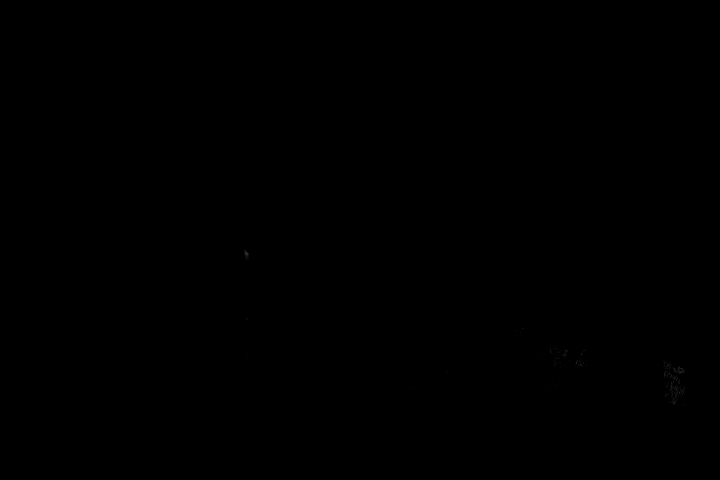

In [21]:
import torch.nn as nn
import torch
import cv2
import numpy as np
from random import randint


get_image()
image = torch.Tensor(np.moveaxis(np.asarray(cv2.imread("test.jpg")), -1, 0)).unsqueeze(0)
image.shape

def get_conv(kernel_size=3, stride=2, padding=True):
  print(f'filter of ({kernel_size}, {kernel_size}) with stride={stride} and padding={padding}')
  if padding:
    return nn.Conv2d(3, 1, kernel_size, stride=stride, 
                     padding=ceil((kernel_size-1)/2))
  return nn.Conv2d(3, 1, kernel_size, stride=stride)

conv2d = get_conv(randint(2, 7), randint(1, 5), True)
out = conv2d(image).detach().numpy().squeeze()
print(f"Image of size {real_image.shape} converted into {out.shape}")
out = cv2.resize(out, (720, 480), cv2.INTER_LINEAR)
cv2_imshow(out)

And that was quite a lot of information to unload but I hope I was able to provide it in a simple but detailed manner. There are alot of references in this and they are definetely recommeded reads for you if you want to understand convolutions in more detail.


Check us out at https://visiongenius.ai.

Arham.